## Краткое описание датасета
**COCO (Common Objects in Context)** — это датасет, содержащий более 200 тысяч изображений с аннотациями, включая метки объектов для задач классификации, детекции, и сегментации. Он акцентирует внимание на реалистичных условиях и сложных сценах, где объекты взаимодействуют друг с другом.

Датасет слишком большой будем анализировать выборку из 5000 изображений и описаний к ним

In [ ]:
# Загрузка
!wget https://storage.yandexcloud.net/yandex-research/train2014_5k.tar.gz
!tar -C "data" -xzf data/train2014_5k.tar.gz

## Загрузка данных

In [22]:
import pandas as pd

# Загрузка данных
annotations = pd.read_csv('data/train2014_5k.csv')

# Просмотр первых строк
annotations.head()

,Unnamed: 0,file_name,caption
0,0,COCO_train2014_000000000009.jpg,A bunch of trays that have different food.
1,1,COCO_train2014_000000000025.jpg,A giraffe standing next to a forest filled wit...
2,2,COCO_train2014_000000000030.jpg,A vase with red and white flowers outside on a...
3,3,COCO_train2014_000000000034.jpg,a Zebra grazing on grass in a green open field.
4,4,COCO_train2014_000000000036.jpg,A girl in a bathing suit with a pink umbrella.


In [23]:
# Основная информация о данных
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   file_name   5000 non-null   object
 2   caption     5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [24]:
# Проверка на пропуски
print("Пропущенные значения:\n", annotations.isnull().sum())

Пропущенные значения:
 Unnamed: 0    0
file_name     0
caption       0
dtype: int64


In [ ]:
# Количество уникальных изображений
print(f"Уникальные изображения: {annotations['file_name'].nunique()} из {len(annotations)} записей")

# Количество уникальных подписей
print(f"Уникальные подписи: {annotations['caption'].nunique()} из {len(annotations)} записей")

Уникальные изображения: 5000 из 5000 записей
Уникальные подписи: 4992 из 5000 записей


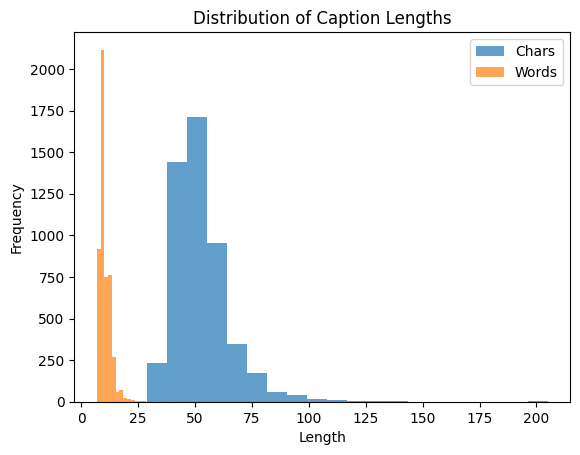

In [13]:
# Длина подписей в символах
annotations['caption_length_chars'] = annotations['caption'].apply(len)

# Длина подписей в словах
annotations['caption_length_words'] = annotations['caption'].apply(lambda x: len(x.split()))

# Гистограммы
import matplotlib.pyplot as plt

plt.hist(annotations['caption_length_chars'], bins=20, alpha=0.7, label="Chars")
plt.hist(annotations['caption_length_words'], bins=20, alpha=0.7, label="Words")
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.legend()
plt.show()

In [15]:
import os

# Путь к изображениям
image_dir = 'data/train2014_5k'

# Проверка существования файлов
annotations['image_exists'] = annotations['file_name'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))

# Статистика по отсутствующим изображениям
missing_images = annotations[~annotations['image_exists']]
print(f"Отсутствуют изображения: {len(missing_images)}")
print(missing_images)

Отсутствуют изображения: 0
Empty DataFrame
Columns: [Unnamed: 0, file_name, caption, caption_length_chars, caption_length_words, image_exists]
Index: []


### Примеры изображений с подписями

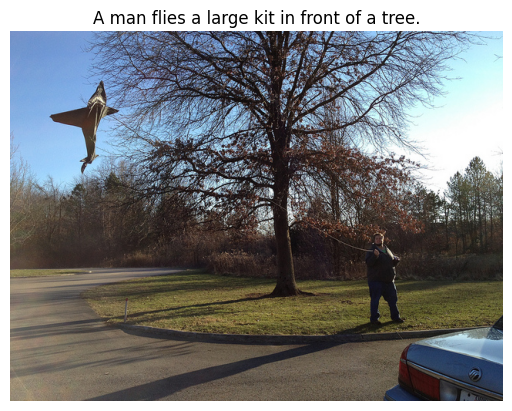

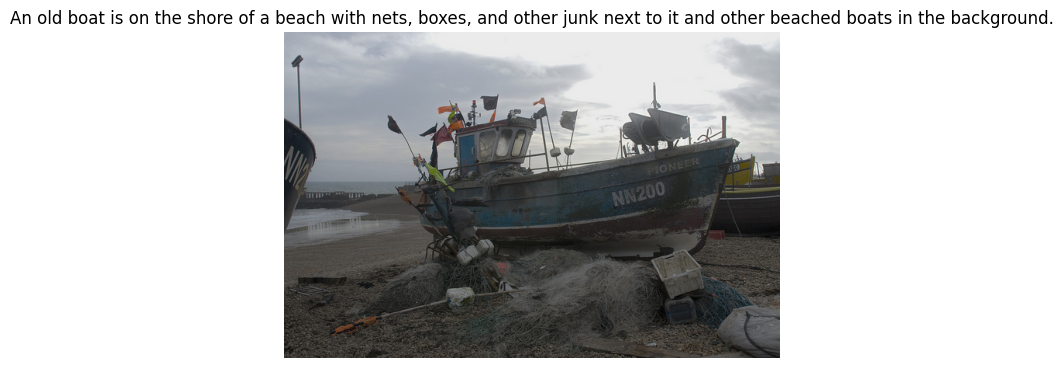

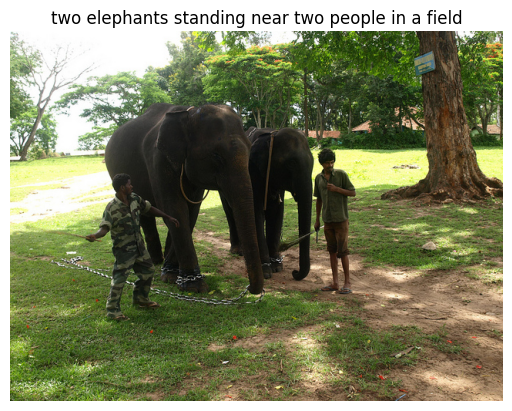

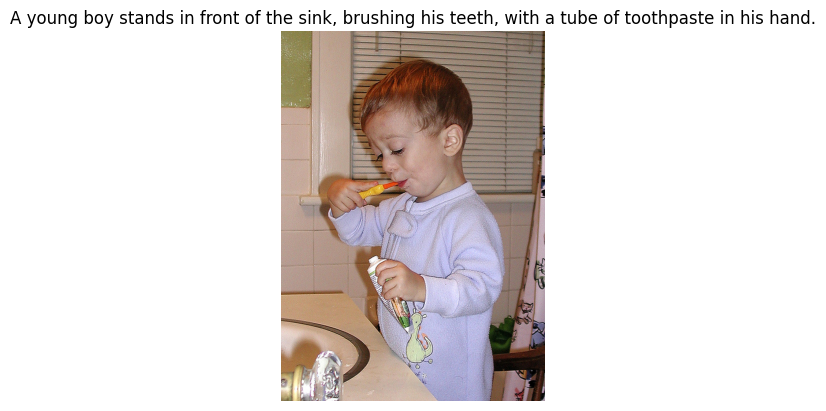

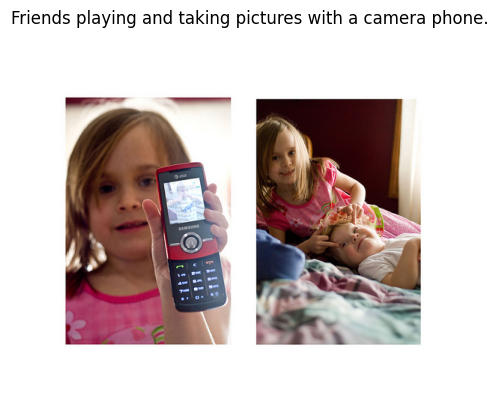

In [ ]:
import cv2
import matplotlib.pyplot as plt


def show_images_with_captions(df, image_dir, n=5):
    sampled_data = df.sample(n)
    for _, row in sampled_data.iterrows():
        img_path = os.path.join(image_dir, row['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(row['caption'])
        plt.axis('off')
        plt.show()

show_images_with_captions(annotations, image_dir)


### Частотный анализ слов

Топ-10 слов:
[('a', 8093), ('on', 1843), ('the', 1685), ('of', 1645), ('in', 1572), ('with', 1326), ('and', 1255), ('is', 859), ('man', 591), ('to', 537)]


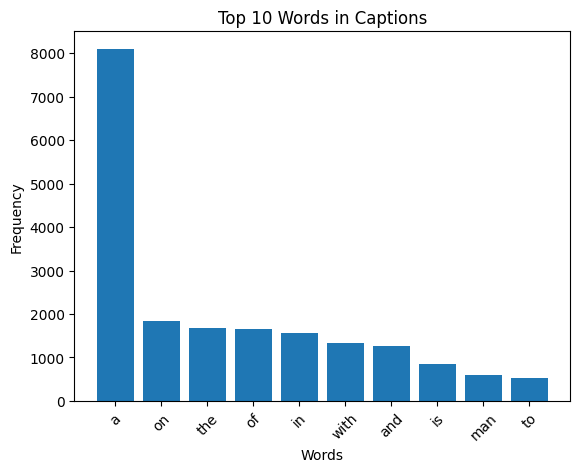

In [17]:
from collections import Counter

# Разбиение всех подписей на слова
all_words = " ".join(annotations['caption'].tolist()).lower().split()

# Частотный анализ
word_counts = Counter(all_words)

# Топ-10 слов
print("Топ-10 слов:")
print(word_counts.most_common(10))

# Гистограмма
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words in Captions')
plt.xticks(rotation=45)
plt.show()

### Кластеризация / Понижение размерности / Метод главных компонент

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

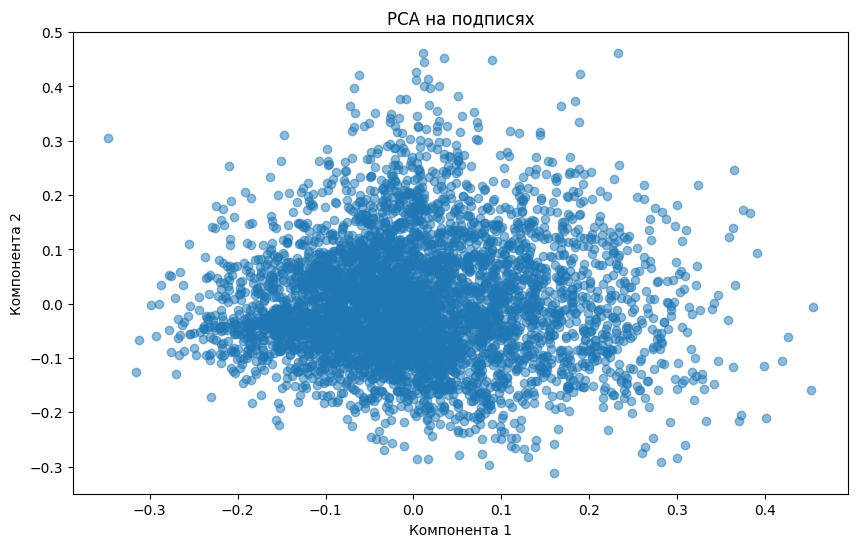

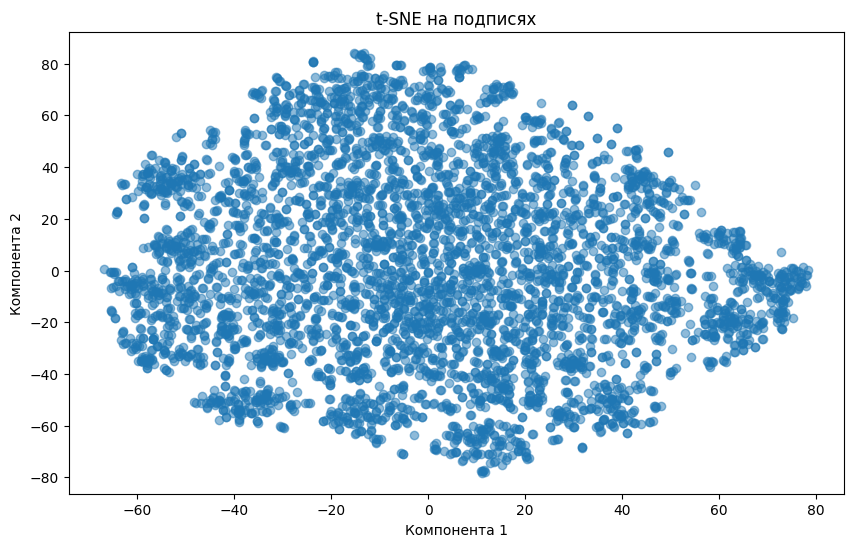

In [20]:
# Преобразование текстов в TF-IDF векторы
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(annotations['caption'])

# Применение PCA для уменьшения размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Визуализация с помощью PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("PCA на подписях")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.show()

# Применение t-SNE для кластеризации
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Визуализация с помощью t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title("t-SNE на подписях")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.show()

## ML Systems Design

COCO предоставляет данные, подходящие для множества задач:

* Image Captioning: Автоматическая генерация текстовых описаний к изображениям.
* Object Detection: Обнаружение объектов на изображении с указанием их классов и координат (bounding boxes).
* Semantic Segmentation: Классификация каждого пикселя изображения.
* Panoptic Segmentation: Объединение задач сегментации и детекции.
* Image Generation: Генерация изображений по промпту.

## Алгоритм 

В моей работе рассматривается задача генерации изображений по текстовому описанию, решение которой описывается в ноутбуке "consistency_distillation.ipynb". Здесь же можно рассмотреть вопрос используемых метрик в такой задаче.

## Метрики

### **Fréchet Inception Distance (FID)**

**Fréchet Inception Distance (FID)** — это метрика для оценки качества сгенерированных изображений, сравнивающая их распределение с распределением реальных изображений в эмбеддинговом пространстве, извлечённом с помощью модели **Inception v3**. В отличие от других метрик, таких как Inception Score, FID учитывает не только визуальное качество изображений, но и их разнообразие, а также близость к реальному распределению.

#### Формула FID:

Формула для вычисления FID между двумя распределениями гауссовых признаков $ \mathcal{N}(\mu_r, \Sigma_r) $  для реальных изображений и $ \mathcal{N}(\mu_g, \Sigma_g) $  для сгенерированных изображений:

$$ 
FID = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$$ 

- $ \mu_r $ , $ \Sigma_r $  — среднее значение и ковариационная матрица признаков для реальных изображений.
- $ \mu_g $ , $ \Sigma_g $  — среднее значение и ковариационная матрица признаков для сгенерированных изображений.
- $ \|\mu_r - \mu_g\|^2 $  — евклидово расстояние между средними значениями.
- $ \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}) $  — след матрицы ковариаций, который измеряет сходство между ковариациями реальных и сгенерированных изображений.

- **FID** оценивает качество изображений на основе статистики признаков, извлечённых моделью, и не измеряет соответствие текста и изображения. Это метрика визуального качества, которая учитывает как сходство, так и разнообразие.
- **Минимизация FID** указывает на улучшение качества генерации изображений.


### **CLIP Score (Contrastive Language-Image Pretraining)**

- **CLIP Score** — это метрика, которая использует CLIP для оценки сходства между изображением и текстом.
  - Сначала вычисляется сходство между эмбеддингами изображения $ f_x(x) $  и текста $ f_t(t) $ .
  - Результат представляет собой косинусное сходство, которое измеряет, насколько хорошо изображение соответствует описанию.

#### Формула CLIP Score:

$$ 
\text{CLIP Score}(x, t) = \frac{f_x(x) \cdot f_t(t)}{\|f_x(x)\| \|f_t(t)\|}
$$ 

где:
- $ x $  — изображение.
- $ t $  — текстовое описание.
- $ f_x(x) $  — эмбеддинг изображения.
- $ f_t(t) $  — эмбеддинг текста.

#### Пояснение:
- **CLIP Score** показывает, насколько изображение соответствует текстовому описанию в контексте общей семантики. Чем выше значение, тем больше сходства между изображением и его описанием.


Обе метрики полезны в разных контекстах:
- **FID** лучше подходит для оценки генерации изображений в целом.
- **CLIP** предоставляет точную оценку соответствия между изображением и его текстовым описанием, что особенно полезно в задачах **image captioning** или **text-to-image generation**.

## Сравнение датасета с аналогами
Аналоги COCO:

* Flickr30k:   
30,000 изображений с текстовыми аннотациями.   
Основное отличие: меньше данных, но аннотации более связаны с визуальными деталями.

* Visual Genome:   
Содержит более 100,000 изображений.   
Дополнительно включает графы сцен, что делает его более детализированным.

* Conceptual Captions:   
Автоматически сгенерированные текстовые описания для более 3 миллионов изображений.   
Отличие: менее качественные аннотации из-за автоматической генерации.

Преимущества и недостатки COCO:
* Преимущества: Высокое качество подписей, широкий диапазон объектов и ситуаций.
* Недостатки: Ограниченность контекстов, не всегда глубокая семантическая информация в подписях.